This script clusters the different features and representations exported from .feature_extraction.ipynb.

At the beginning of every run, the dataset is bootstrapped to retrieve different class subset sizes.

1) Nearest neighbour graphs of all representations are created based on euclidian distance
2) Embeddings are created using **UMAP** and **Hopkins** statistic computed for each embeddings- and original feature space
3) The following three clustering algorithms are applied:
    - **kMeans**
    - **HDBSCAN**
    - **Leiden**
4) All resulting clusterings are evaluated with
    - **silhouette score**
    - **V-measure**
    - **Adjusted Rand score**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import random
from tqdm.auto import tqdm

from sklearn.preprocessing import LabelEncoder
import umap
from umap.umap_ import nearest_neighbors
from sklearn.preprocessing import StandardScaler

from sklearn.metrics.cluster import v_measure_score, completeness_score, homogeneity_score
from sklearn.metrics import adjusted_rand_score, silhouette_score

from utils import plotting, clustering, stats
import pickle

/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# For plotting
# sns.set_theme("paper")
CALL_TYPE_COLORS = {'alarm': (0.2823529411764706, 0.47058823529411764, 0.8156862745098039), 
                    'contact': (0.9333333333333333, 0.5215686274509804, 0.2901960784313726), 
                    'departure': (0.41568627450980394, 0.8, 0.39215686274509803), 
                    'distance': (0.8392156862745098, 0.37254901960784315, 0.37254901960784315), 
                    'recruitment': (0.5843137254901961, 0.4235294117647059, 0.7058823529411765), 
                    'triumph': (0.5490196078431373, 0.3803921568627451, 0.23529411764705882)}
DOT_SIZE = 10
ALPHA = .5

In [3]:
columns = [
    'Representation', 
    'Algorithm', 
    'Distance metric', 
    'Subset size', 
    'Cluster labels', 
    'V-measure', 
    'Adj. RS', 
    'Hopkins', 
    'Silhouette Score', 
    'Modularity',
    'Homogeneity',
    'Completeness'
    ]

results_df = pd.DataFrame(columns=columns)

In [4]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.RandomState(RANDOM_SEED)

RandomState(MT19937) at 0x12B03A940

In [5]:
# List of titles for plots of PAFs
feature_titles_list = [
    "Duration [s]",
    "Temporal 1st Quartile [s]", 
    "Temporal Median [s]", 
    "Temporal 3rd Quartile [s]", 
    "Temporal Standard Deviation [s]", 
    "Temporal Skewness", 
    "Temporal Kurtosis", 
    "Temporal Entropy", 
    "Mean Frequency [kHz]",
    "Mean Peak Frequency [kHz]",
    "Spectral Sandard Deviation [kHz]",
    "Spectral Flatness", 
    "Frequency 1st Quartile [kHz]",
    "Frequency Median [kHz]", 
    "Frequency 3rd Quartile [kHz]", 
    "Mean Dominant Frequency [kHz]", 
    "Min Dominant Frequency [kHz]",
    "Max Dominant Frequency [kHz]", 
    "Dominant Frequency Range [kHz]", 
    "Dominant Frequency Modulation [kHz]", 
    "Spectral Entropy", 
    "Harmonics-to-Noise Ratio [dB]",
    "Spectrographic Entropy"
    ]

# List of column names of PAFs
feature_columns_list = [
    "duration",
    "t_q1", 
    "t_median", 
    "t_q3", 
    "std_t", 
    "skew_t", 
    "kurt_t", 
    "t_entropy", 
    "mean_f",
    "mean_peak_f", 
    "std_f",
    "flatness_s", 
    "f_q1",
    "f_median", 
    "f_q3", 
    "mean_dom", 
    "min_dom",
    "max_dom", 
    "range_dom", 
    "mod_dom", 
    "pse", 
    "hnr",
    "spectrographic_entropy"
    ]

# Import the dataset

In [6]:
calls_df = pd.read_csv('features_and_spectrograms.csv')
calls_df['log_padded_spectrogram'] = calls_df['log_padded_spectrogram'].apply(lambda x: np.array(json.loads(x)))
calls_df['log_padded_log_freq_spectrogram'] = calls_df['log_padded_log_freq_spectrogram'].apply(lambda x: np.array(json.loads(x)))
calls_df['log_padded_lfccs'] = calls_df['log_padded_lfccs'].apply(lambda x: np.asarray(json.loads(x)))
calls_df['log_padded_mfccs'] = calls_df['log_padded_mfccs'].apply(lambda x: np.asarray(json.loads(x)))

In [7]:
# import latent representations from VAE and merge with calls df
representations_df = pd.read_csv("pickles_and_csvs/latent_representations_CVAE.csv")
representations_df["latent_representation"] = representations_df["latent_representation"].apply(lambda x: np.asarray(json.loads(x)))
calls_df = pd.merge(calls_df, representations_df, on="clip_ID")
calls_df = calls_df.drop(columns=["call_type_y"])
calls_df = calls_df.rename(columns={"call_type_x": "call_type"})

In [8]:
print(len(calls_df[calls_df.isna().any(axis=1)]))
calls_df = calls_df.dropna()
calls_df.info()

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 40 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   track_ID                         7043 non-null   object 
 1   clip_ID                          7043 non-null   object 
 2   goose_ID                         7043 non-null   object 
 3   call_type                        7043 non-null   object 
 4   waveform                         7043 non-null   object 
 5   sr                               7043 non-null   int64  
 6   filepath                         7043 non-null   object 
 7   log_scaled_spectrogram           7043 non-null   object 
 8   lfccs                            7043 non-null   object 
 9   mfccs                            7043 non-null   object 
 10  peak                             7043 non-null   float64
 11  duration                         7043 non-null   float64
 12  log_padded_spectro

/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_59089/1510808998.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  hist = sns.histplot(


[]

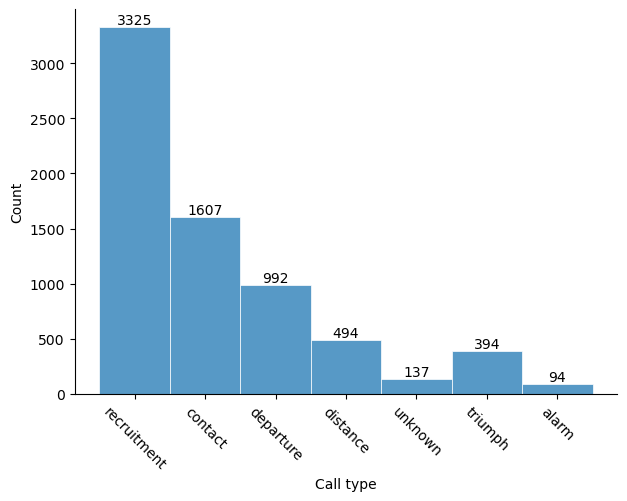

In [9]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

hist = sns.histplot(
    calls_df,
    x="call_type",
    multiple="stack",
    palette="viridis",
    edgecolor="1",
    linewidth=.5,
)

plt.xticks(rotation=-45)
ax.set_xlabel("Call type")

# Add counts
for p in hist.patches:
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2
    ax.annotate(f'{int(height)}', (x, height), ha='center', va='bottom')
    
plt.plot()

In [10]:
# Group discard unknown calls
calls_df = calls_df[calls_df['call_type']!='unknown']

## Bootstrap to subset size and run pipeline

In [11]:
def create_representations_subdf_and_scale(full_df, column_name, column_names=["call_type", "track_ID", "goose_ID"]):
    column_names_new_df = column_names.copy()
    subset_list = []
    for idx, row in full_df.iterrows():
        subset_list.append([row["call_type"], row["track_ID"], row["goose_ID"], *row[column_name].flatten()])

    for i in range(len(full_df.iloc[0][column_name].flatten())):
        column_names_new_df.append(i)

    subset_df = pd.DataFrame(subset_list, columns=column_names_new_df, index=None)
    subset_df.head()

    subset_scaled = StandardScaler().fit_transform(subset_df.drop(columns=column_names))

    return subset_scaled, subset_df

In [12]:
N_NEIGHBORS = 15
DISTANCE_METRIC = "euclidean"

In [ ]:
# run for different subset sizes
for subset_size in [50, 95, 200, 500]:
    # bootstrap dataset
    for i in tqdm(range(50)):
        subset_df = clustering.bootstrap_classes_of_size(calls_df, subset_size)

        # Encode call type
        le = LabelEncoder()
        le.fit(subset_df["call_type"])
        subset_df["encoded_call_type"] = le.transform(subset_df["call_type"])

        # Load representation dataframes
        paf_scaled = StandardScaler().fit_transform(subset_df.drop(columns=[col for col in calls_df.columns if col not in feature_columns_list])) #["call_type", "track_ID", "clip_ID", "goose_ID", "waveform", "sr", "filepath", "log_scaled_spectrogram", "log_padded_spectrogram", "log_padded_mfccs", "log_padded_log_freq_spectrogram", "lfccs", "log_padded_lfccs", "latent_representation", "duration_paf"]
        lfccs_scaled, lfccs_df = create_representations_subdf_and_scale(subset_df, "log_padded_lfccs")
        spectrograms_scaled, spectrograms_df = create_representations_subdf_and_scale(subset_df, "log_padded_spectrogram")
        _, vae_df = create_representations_subdf_and_scale(subset_df, "latent_representation")

        # NN Graphs
        nn_results_paf = nearest_neighbors(paf_scaled, n_neighbors=N_NEIGHBORS, metric=DISTANCE_METRIC, metric_kwds={}, angular=False, random_state=RANDOM_SEED, verbose=False)
        nn_results_lfcc = nearest_neighbors(lfccs_scaled, n_neighbors=N_NEIGHBORS, metric=DISTANCE_METRIC, metric_kwds={}, angular=False, random_state=RANDOM_SEED, verbose=False)
        nn_results_spec = nearest_neighbors(spectrograms_scaled, n_neighbors=N_NEIGHBORS, metric=DISTANCE_METRIC, metric_kwds={}, angular=False, random_state=RANDOM_SEED, verbose=False)
        nn_results_vae = nearest_neighbors(vae_df.drop(columns=["call_type", "track_ID", "goose_ID"]), n_neighbors=N_NEIGHBORS, metric=DISTANCE_METRIC, metric_kwds={}, angular=False, random_state=RANDOM_SEED, verbose=False)
        
        # Reduce dimensionality
        embeddings_paf = umap.UMAP(precomputed_knn=nn_results_paf, n_neighbors=15, n_components=2, min_dist=0.1, random_state=RANDOM_SEED, n_jobs=1).fit_transform(paf_scaled)
        embeddings_lfcc = umap.UMAP(precomputed_knn=nn_results_lfcc, n_neighbors=15, n_components=2, min_dist=0.1, random_state=RANDOM_SEED, n_jobs=1).fit_transform(lfccs_scaled)
        embeddings_spec = umap.UMAP(precomputed_knn=nn_results_spec, n_neighbors=15, n_components=2, min_dist=0.1, random_state=RANDOM_SEED, n_jobs=1).fit_transform(spectrograms_scaled)
        embeddings_vae = umap.UMAP(precomputed_knn=nn_results_vae, n_neighbors=15, n_components=2, min_dist=0.1, random_state=RANDOM_SEED, n_jobs=1).fit_transform(vae_df.drop(columns=["call_type", "track_ID", "goose_ID"]))

        # Cluster
        # kMeans preset
        _, _, labels_kMeans_preset_paf = clustering.silhouette_analysis_kmeans(embeddings_paf, range_n_clusters=[6], plot_best_clustering=False)
        _, _, labels_kMeans_preset_lfcc = clustering.silhouette_analysis_kmeans(embeddings_lfcc, range_n_clusters=[6], plot_best_clustering=False)
        _, _, labels_kMeans_preset_spec = clustering.silhouette_analysis_kmeans(embeddings_spec, range_n_clusters=[6], plot_best_clustering=False)
        _, _, labels_kMeans_preset_vae = clustering.silhouette_analysis_kmeans(embeddings_vae, range_n_clusters=[6], plot_best_clustering=False)

        # kMeans
        _, _, labels_kMeans_paf = clustering.silhouette_analysis_kmeans(embeddings_paf, plot_best_clustering=False)
        _, _, labels_kMeans_lfcc = clustering.silhouette_analysis_kmeans(embeddings_lfcc, plot_best_clustering=False)
        _, _, labels_kMeans_spec = clustering.silhouette_analysis_kmeans(embeddings_spec, plot_best_clustering=False)
        _, _, labels_kMeans_vae = clustering.silhouette_analysis_kmeans(embeddings_vae, plot_best_clustering=False)

        # HDBSCAN
        _, _, labels_HDBSCAN_paf = clustering.silhouette_analysis_hdbscan(embeddings_paf, plot_best_clustering=False)
        _, _, labels_HDBSCAN_lfcc = clustering.silhouette_analysis_hdbscan(embeddings_lfcc, plot_best_clustering=False)
        _, _, labels_HDBSCAN_spec = clustering.silhouette_analysis_hdbscan(embeddings_spec, plot_best_clustering=False)
        _, _, labels_HDBSCAN_vae = clustering.silhouette_analysis_hdbscan(embeddings_vae, plot_best_clustering=False)

        # Leiden
        _, _, labels_Leiden_paf, partition_paf = clustering.modularity_analysis_leiden(nn_results_paf, subset_df, "leiden_cluster_paf", embeddings=embeddings_paf, plot_every_step=False, plot_best_clustering=False)
        _, _, labels_Leiden_lfcc, partition_lfcc = clustering.modularity_analysis_leiden(nn_results_lfcc, subset_df, "leiden_cluster_lfcc", embeddings=embeddings_lfcc, plot_every_step=False, plot_best_clustering=False)
        _, _, labels_Leiden_spec, partition_spectrogram = clustering.modularity_analysis_leiden(nn_results_spec, subset_df, "leiden_cluster_spectrogram", embeddings=embeddings_spec, plot_every_step=False, plot_best_clustering=False)
        _, _, labels_Leiden_vae, partition_vae = clustering.modularity_analysis_leiden(nn_results_vae, subset_df, "leiden_cluster_vae", embeddings=embeddings_vae, plot_every_step=False, plot_best_clustering=False)

        # Leiden preset
        # TODO

        # plotting.plot_embeddings_with_colorcoded_label(subset_df, embeddings_paf, "call_type", "UMAP embeddings of PAFs", "Call Type")
        # plotting.plot_embeddings_with_colorcoded_label(subset_df, embeddings_lfcc, "call_type", "UMAP embeddings of LFCCs", "Call Type")
        # plotting.plot_embeddings_with_colorcoded_label(subset_df, embeddings_spec, "call_type", "UMAP embeddings of spectrograms", "Call Type")
        # plotting.plot_embeddings_with_colorcoded_label(subset_df, embeddings_vae, "call_type", "UMAP embeddings of VAE representations", "Call Type")

        # plotting.plot_embeddings_with_colorcoded_label(subset_df, embeddings_paf, "goose_ID", "UMAP embeddings of PAFs - Goose ID", show_legend=False)
        # plotting.plot_embeddings_with_colorcoded_label(subset_df, embeddings_lfcc, "goose_ID", "UMAP embeddings of LFCCs - Goose ID", show_legend=False)
        # plotting.plot_embeddings_with_colorcoded_label(subset_df, embeddings_spec, "goose_ID", "UMAP embeddings of spectrograms - Goose ID", show_legend=False)
        # plotting.plot_embeddings_with_colorcoded_label(subset_df, embeddings_vae, "goose_ID", "UMAP embeddings of VAE representations - Goose ID", show_legend=False)

        # plotting.plot_embeddings_with_colorcoded_label(subset_df, embeddings_paf, "track_ID", "UMAP embeddings of PAFs - Track ID", show_legend=False)
        # plotting.plot_embeddings_with_colorcoded_label(subset_df, embeddings_lfcc, "track_ID", "UMAP embeddings of LFCCs - Track ID", show_legend=False)
        # plotting.plot_embeddings_with_colorcoded_label(subset_df, embeddings_spec, "track_ID", "UMAP embeddings of spectrograms - Track ID", show_legend=False)
        # plotting.plot_embeddings_with_colorcoded_label(subset_df, embeddings_vae, "track_ID", "UMAP embeddings of VAE representations - Track ID", show_legend=False)

        # Append to results DataFrame
        representations = [
            ("PAF", embeddings_paf, partition_paf, labels_kMeans_preset_paf, labels_kMeans_paf, labels_HDBSCAN_paf, labels_Leiden_paf),
            ("LFCC", embeddings_lfcc, partition_lfcc, labels_kMeans_preset_lfcc, labels_kMeans_lfcc, labels_HDBSCAN_lfcc, labels_Leiden_lfcc),
            ("Spectrogram", embeddings_spec, partition_spectrogram, labels_kMeans_preset_spec, labels_kMeans_spec, labels_HDBSCAN_spec, labels_Leiden_spec),
            ("VAE", embeddings_vae, partition_vae, labels_kMeans_preset_vae, labels_kMeans_vae, labels_HDBSCAN_vae, labels_Leiden_vae),
        ]

        algorithms = [
            ("kMeans-preset", 3),     
            ("kMeans", 4), 
            ("HDBSCAN", 5),
            ("Leiden", 6), 
        ]

        for rep_name, embeddings, partition, labels_kMeans_preset, labels_kMeans, labels_HDBSCAN, labels_Leiden in representations:
            for algorithm_name, label_index in algorithms:
                labels = [labels_kMeans_preset, labels_kMeans, labels_HDBSCAN, labels_Leiden][label_index - 3]
                new_row = {
                    "Representation": rep_name,
                    "Algorithm": algorithm_name,
                    "Distance metric": DISTANCE_METRIC,
                    "Subset size": subset_size,
                    "N clusters": np.max(labels)+1,
                    "V-measure": v_measure_score(subset_df["encoded_call_type"], labels),
                    "Adj. RS": adjusted_rand_score(subset_df["encoded_call_type"], labels),
                    "Hopkins": stats.hopkins(embeddings, RANDOM_SEED),  # Replace with actual calculation
                    "Silhouette Score": silhouette_score(embeddings, labels) if algorithm_name!="Leiden" else None,
                    "Modularity": partition.modularity if algorithm_name=="Leiden" else None,
                    "Homogeneity": homogeneity_score(subset_df["encoded_call_type"], labels) if algorithm_name!="Leiden" else None,
                    "Completeness": completeness_score(subset_df["encoded_call_type"], labels) if algorithm_name!="Leiden" else None,
                }
                results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)


In [14]:
lfccs_df.head()

call_type track_ID    goose_ID    0    1    2    3    4    5    6  ...  \
0     alarm  GT01068     unknown  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1     alarm  GT00076     Dimitri  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2     alarm  GT00054  Lausbursch  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
3     alarm  GT00057  Besenstiel  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
4     alarm  GT00052    Dagobert  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

   3478  3479  3480  3481  3482  3483  3484  3485  3486  3487  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 3491 columns]

In [15]:
spectrograms_df.head()

call_type track_ID    goose_ID    0    1    2    3    4    5    6  ...  \
0     alarm  GT01068     unknown  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1     alarm  GT00076     Dimitri  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2     alarm  GT00054  Lausbursch  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
3     alarm  GT00057  Besenstiel  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
4     alarm  GT00052    Dagobert  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

   7382  7383  7384  7385  7386  7387  7388  7389  7390  7391  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 7395 columns]

In [16]:
vae_df.head()

call_type track_ID    goose_ID         0         1         2         3  \
0     alarm  GT01068     unknown -0.643474 -1.475240  0.154479  0.232640   
1     alarm  GT00076     Dimitri -0.502580 -0.788689  0.156275 -1.279362   
2     alarm  GT00054  Lausbursch  0.569461 -0.694095  0.322831  0.171435   
3     alarm  GT00057  Besenstiel -0.495890 -1.577023 -0.024826 -1.312015   
4     alarm  GT00052    Dagobert  0.052115 -1.489974  0.109772 -0.387645   

          4         5         6  ...       118       119       120       121  \
0 -0.026742 -2.910513 -5.021040  ... -0.017308  3.089277  0.158025 -0.932267   
1  0.324174 -2.661449 -3.710927  ...  1.091768  1.630437 -0.736371 -0.442224   
2 -0.071304 -2.170059 -5.074318  ...  1.360236  2.030468 -0.917641 -0.204739   
3 -0.002009 -1.015707 -4.316031  ...  1.306128  1.280626  0.534787 -0.816299   
4  0.233106 -1.894170 -4.753716  ...  0.976109  2.234818 -1.345502 -1.168914   

        122       123       124       125       126       127  
0  0.664754  0.740066 -2.266549 -0.319112  1.217784  0.496640  
1 -1.414014 -0.612519 -2.569771 -0.922440  1.621023  0.342285  
2 -0.874868 -0.319963 -2.960915 -0.394549  1.780474  1.627549  
3 -1.238644 -0.721709 -2.209336 -1.271486  2.589400 -0.645880  
4 -1.311017 -0.877919 -2.749129 -0.893923  1.867902  1.012649  

[5 rows x 131 columns]

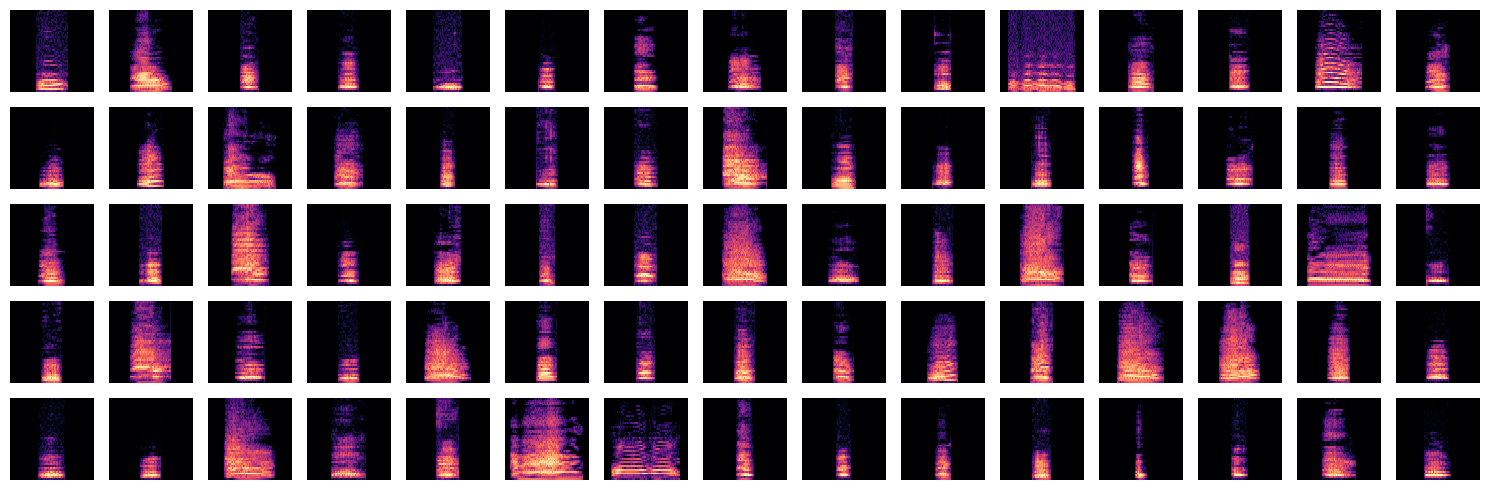

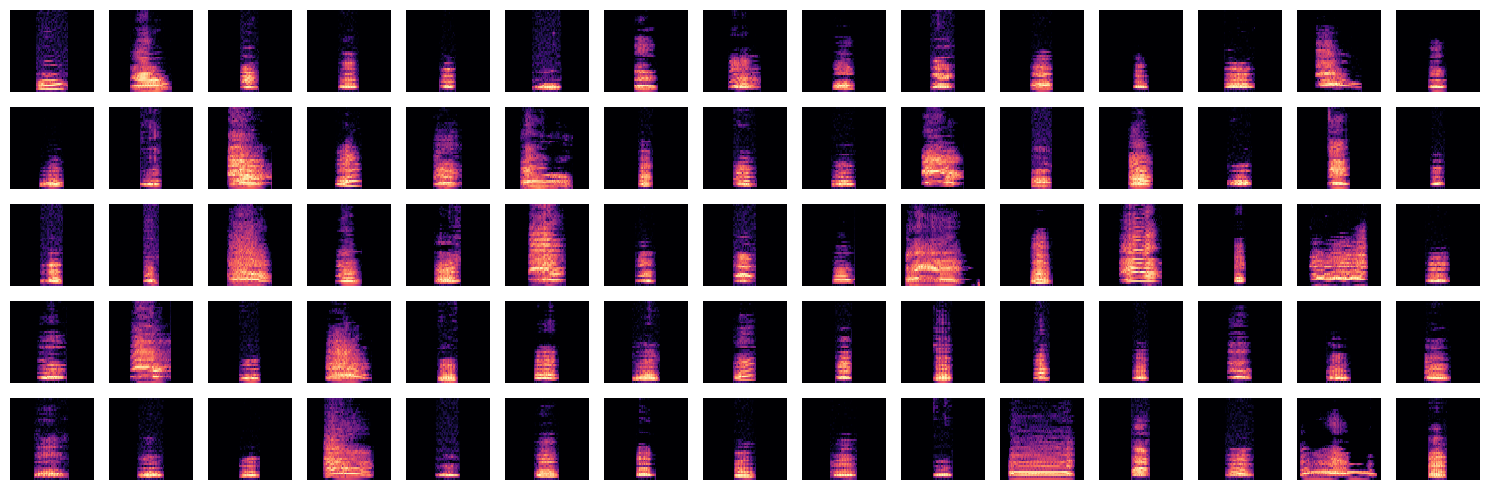

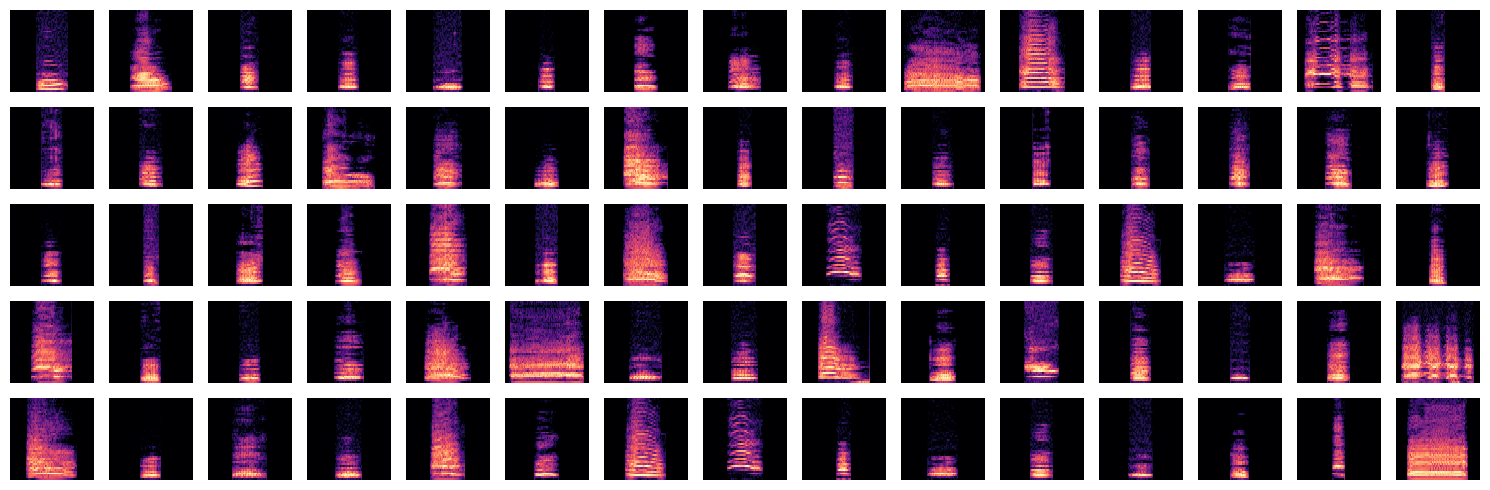

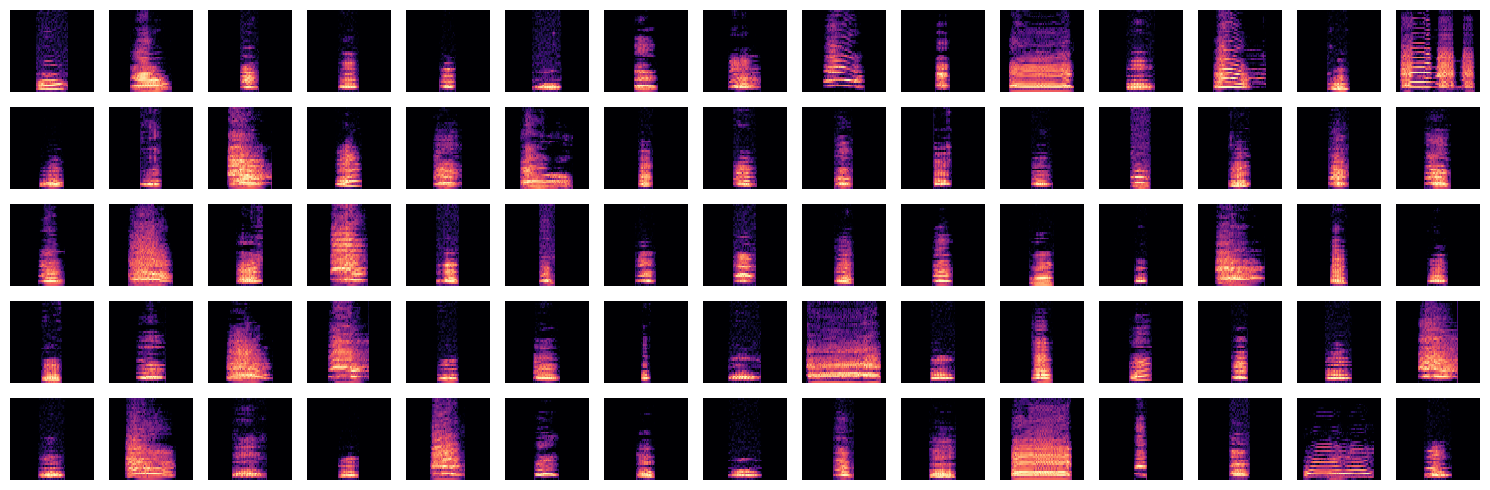

In [17]:
plotting.display_nearest_neighbours(nn_results_paf, calls_df)
plotting.display_nearest_neighbours(nn_results_lfcc, calls_df)
plotting.display_nearest_neighbours(nn_results_spec, calls_df)
plotting.display_nearest_neighbours(nn_results_vae, calls_df)

In [19]:
# plotting.plot_embeddings_with_colorcoded_label(calls_df, embeddings_paf, "call_type", "UMAP embeddings of PAFs", "Call Type")
# plotting.plot_embeddings_with_colorcoded_label(calls_df, embeddings_lfcc, "call_type", "UMAP embeddings of LFCCs", "Call Type")
# plotting.plot_embeddings_with_colorcoded_label(calls_df, embeddings_spec, "call_type", "UMAP embeddings of spectrograms", "Call Type")
# plotting.plot_embeddings_with_colorcoded_label(calls_df, embeddings_vae, "call_type", "UMAP embeddings of VAE representations", "Call Type")

# plotting.plot_embeddings_with_colorcoded_label(calls_df, embeddings_paf, "goose_ID", "UMAP embeddings of PAFs - Goose ID", show_legend=False)
# plotting.plot_embeddings_with_colorcoded_label(calls_df, embeddings_lfcc, "goose_ID", "UMAP embeddings of LFCCs - Goose ID", show_legend=False)
# plotting.plot_embeddings_with_colorcoded_label(calls_df, embeddings_spec, "goose_ID", "UMAP embeddings of spectrograms - Goose ID", show_legend=False)
# plotting.plot_embeddings_with_colorcoded_label(calls_df, embeddings_vae, "goose_ID", "UMAP embeddings of VAE representations - Goose ID", show_legend=False)

# plotting.plot_embeddings_with_colorcoded_label(calls_df, embeddings_paf, "track_ID", "UMAP embeddings of PAFs - Track ID", show_legend=False)
# plotting.plot_embeddings_with_colorcoded_label(calls_df, embeddings_lfcc, "track_ID", "UMAP embeddings of LFCCs - Track ID", show_legend=False)
# plotting.plot_embeddings_with_colorcoded_label(calls_df, embeddings_spec, "track_ID", "UMAP embeddings of spectrograms - Track ID", show_legend=False)
# plotting.plot_embeddings_with_colorcoded_label(calls_df, embeddings_vae, "track_ID", "UMAP embeddings of VAE representations - Track ID", show_legend=False)

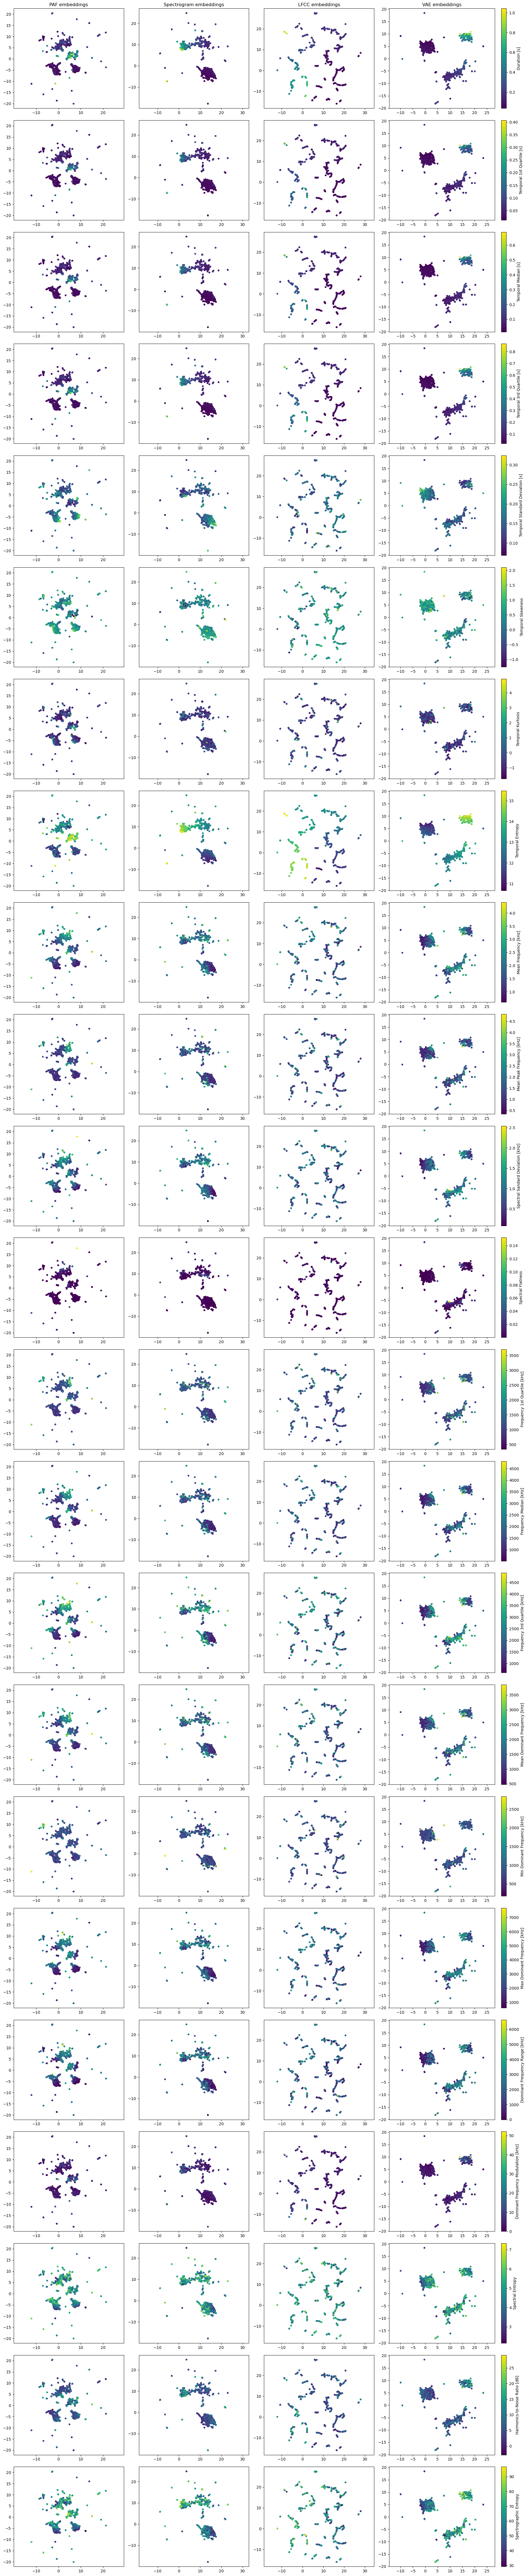

In [21]:
plotting.plot_colorcoded_features(
    feature_columns_list, 
    feature_titles_list, 
    [embeddings_paf, embeddings_spec, embeddings_lfcc, embeddings_vae], 
    ["PAF embeddings", "Spectrogram embeddings", "LFCC embeddings", "VAE embeddings"], 
    subset_df)

In [ ]:
plotting.plot_cluster_examples("leiden_cluster_paf", np.unique(labels_Leiden_paf), calls_df)
plotting.plot_cluster_examples("leiden_cluster_lfcc", np.unique(labels_Leiden_lfcc), calls_df)
plotting.plot_cluster_examples("leiden_cluster_spectrogram", np.unique(labels_Leiden_spec), calls_df)
plotting.plot_cluster_examples("leiden_cluster_vae", np.unique(labels_Leiden_vae), calls_df)

In [ ]:
plotting.scatter_spec(embeddings_paf, calls_df["log_padded_spectrogram"], scatter_kwargs={"alpha": 0.5, "s": 1, "labels": calls_df["call_type"]})
plotting.scatter_spec(embeddings_lfcc, calls_df["log_padded_spectrogram"], scatter_kwargs={"alpha": 0.5, "s": 1, "labels": calls_df["call_type"]})
plotting.scatter_spec(embeddings_spec, calls_df["log_padded_spectrogram"], scatter_kwargs={"alpha": 0.5, "s": 1, "labels": calls_df["call_type"]})
plotting.scatter_spec(embeddings_vae, calls_df["log_padded_spectrogram"], scatter_kwargs={"alpha": 0.5, "s": 1, "labels": calls_df["call_type"]})

In [22]:
results_df.head()

Representation      Algorithm Distance metric Subset size Cluster labels  \
0            PAF  kMeans-preset       euclidean          50            NaN   
1            PAF         kMeans       euclidean          50            NaN   
2            PAF        HDBSCAN       euclidean          50            NaN   
3            PAF         Leiden       euclidean          50            NaN   
4           LFCC  kMeans-preset       euclidean          50            NaN   

   V-measure   Adj. RS   Hopkins  Silhouette Score  Modularity  Homogeneity  \
0   0.511153  0.348799  0.833662          0.465425         NaN     0.500996   
1   0.271934  0.162080  0.833662          0.584776         NaN     0.185695   
2   0.271934  0.162080  0.833662          0.584776         NaN     0.185695   
3   0.555525  0.452475  0.833662               NaN    0.637838          NaN   
4   0.443978  0.327046  0.962220          0.635181         NaN     0.437787   

   Completeness  
0      0.521731  
1      0.507728  
2      0.507728  
3           NaN  
4      0.450347

In [37]:
# export results_df
results_df.to_csv("pickles_and_csvs/results_bootstrapped_50.pkl", index=False)

# Inspect metrics

/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_59089/4094406977.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(columns, rotation=45, ha='right')
/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_59089/4094406977.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(columns, rotation=45, ha='right')
/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_59089/4094406977.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(columns, rotation=45, ha='right')
/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_59089/4094406977.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. a

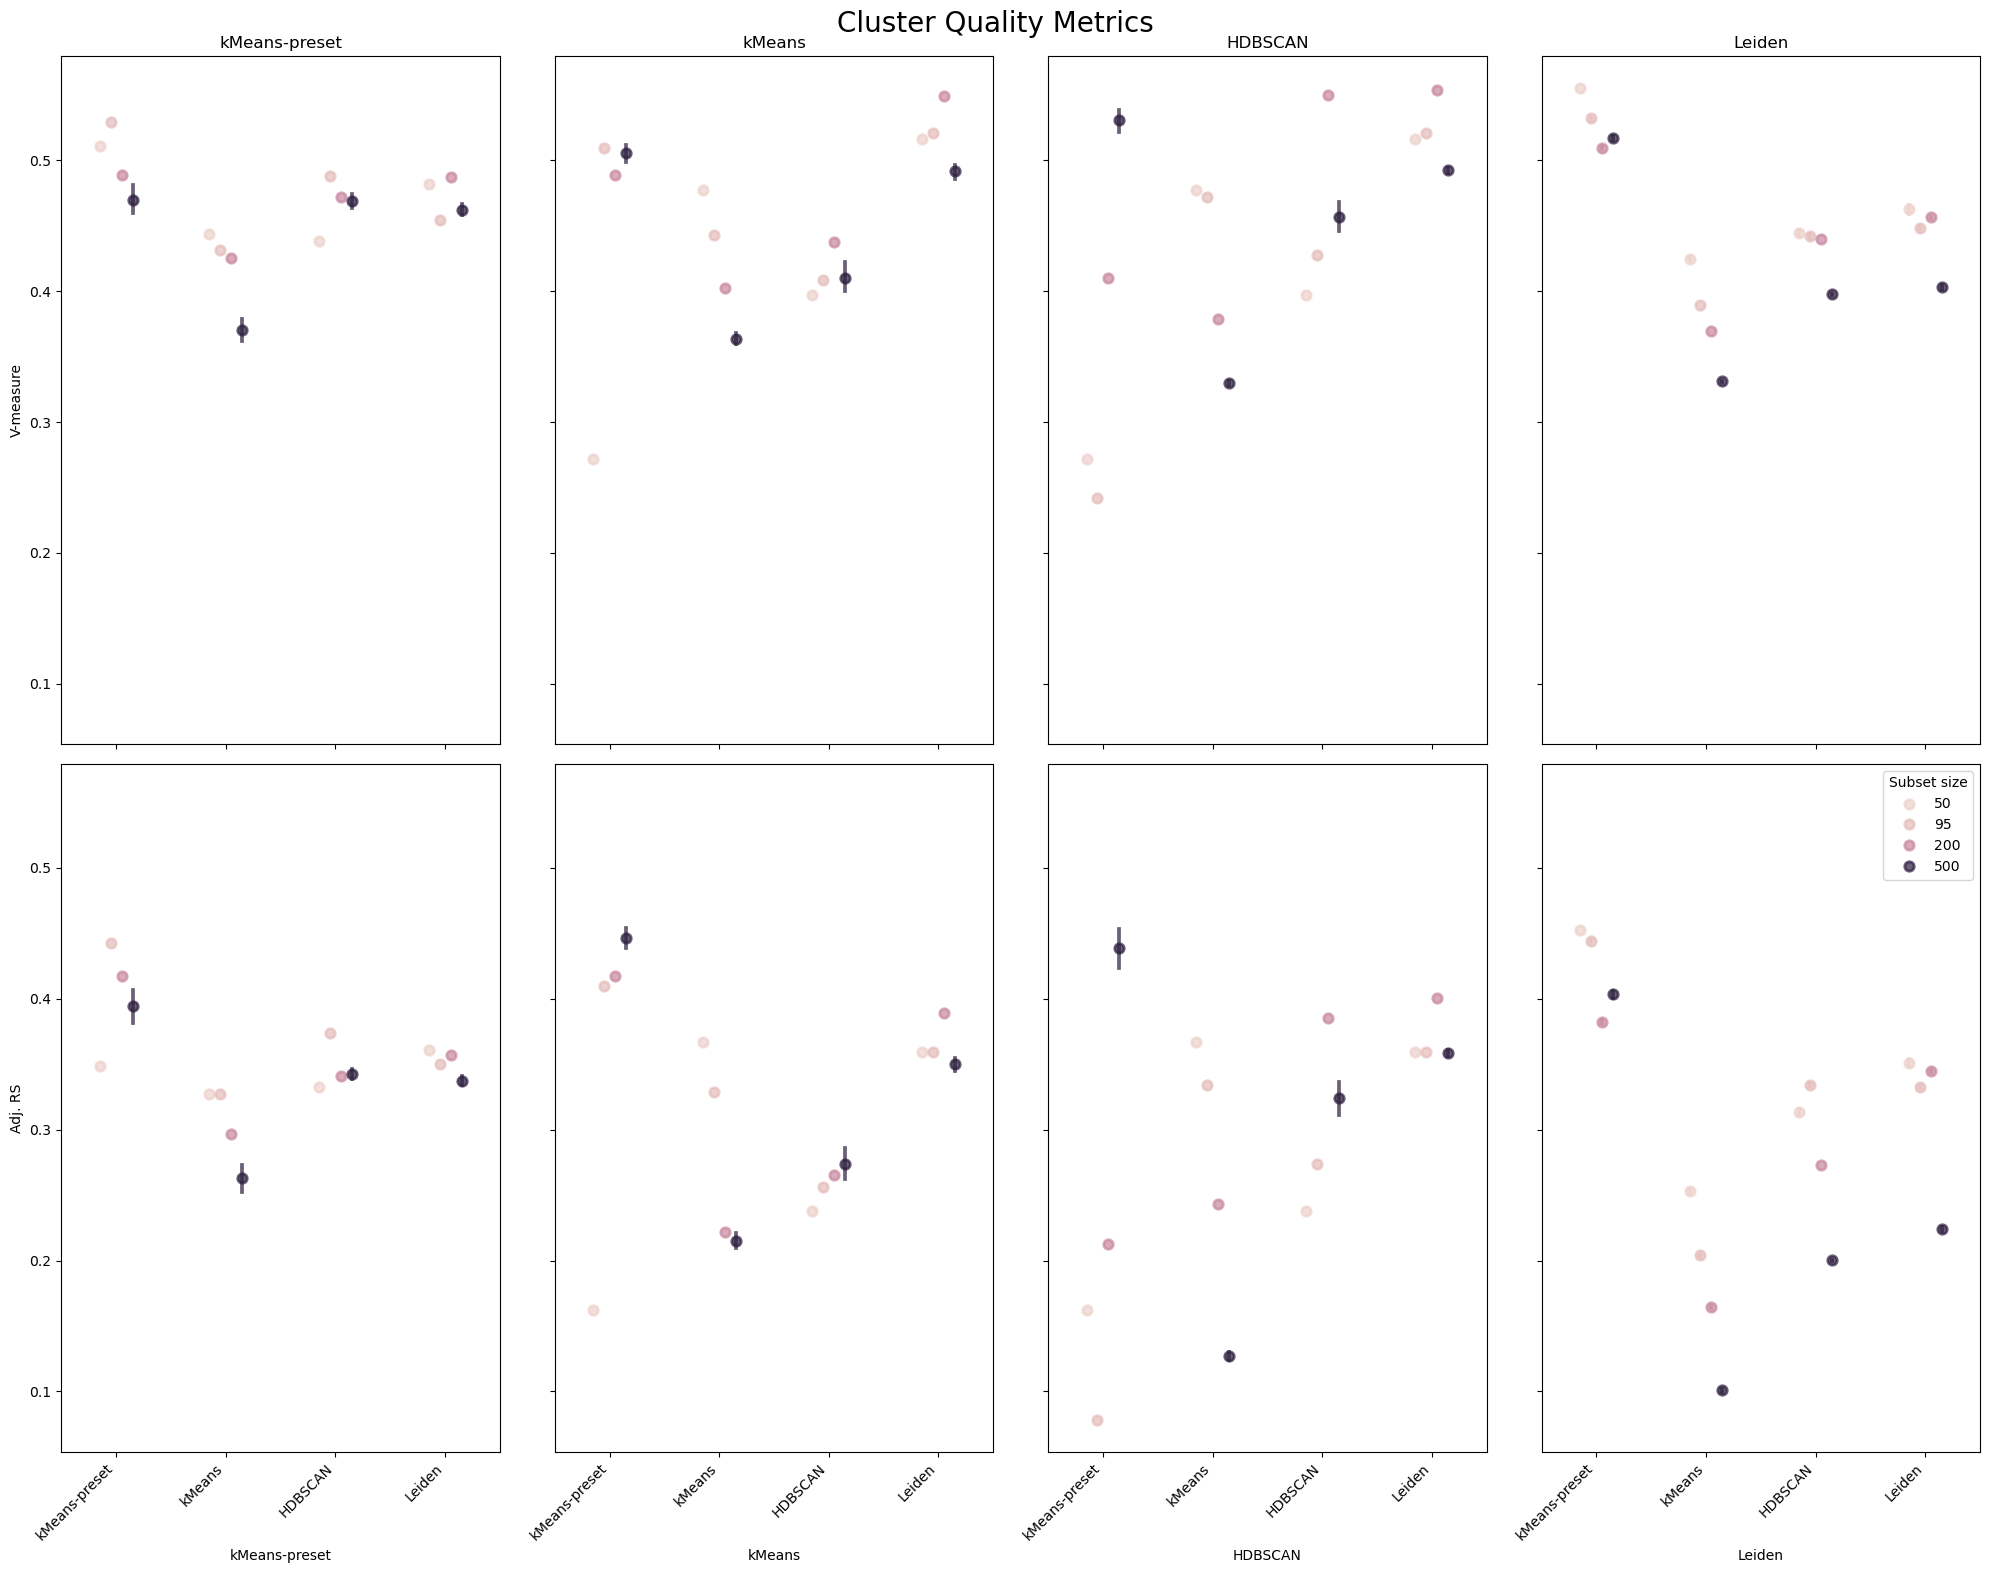

In [36]:
from statannotations.Annotator import Annotator
rows = ["V-measure", "Adj. RS"]
columns = ["kMeans-preset", "kMeans", "HDBSCAN", "Leiden"]
pairs = [("PAF", "LFCC"), 
       ("PAF", "Spectrogram"), 
       ("PAF", "VAE"), 
       ("LFCC", "Spectrogram"), 
       ("LFCC", "VAE"), 
       ("Spectrogram", "VAE")]

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 16), sharex=True, sharey=True)
for row, metric in enumerate(rows):
    for col, representation in enumerate(columns):
        data = results_df[results_df["Algorithm"] == representation]

        sns.pointplot(
            x="Representation", 
            y=metric,  
            data=data, 
            ax=axs[row, col], 
            hue="Subset size", 
            linestyle="none",
            alpha=.7,
            errorbar="ci",
            dodge=.3,
            legend=(True if row==1 and col==3 else False)
        )
        # annotator = Annotator(axs[row, col], data=data, x="Representation", y=metric, pairs=pairs)
        # annotator.configure(test='t-test_paired', text_format='star', loc='outside')
        # annotator.apply_and_annotate()

        if row == 0:
            axs[row, col].set_title(representation)

        #axs[row, col].set_ylim(0.1, 0.7)
        axs[row, col].set_xticklabels(columns, rotation=45, ha='right')
        axs[row, col].set_xlabel(representation)

        if col == 0:
            axs[row, col].set_ylabel(metric)  # Label only the first column
        else:
            axs[row, col].set_ylabel('')

fig.suptitle("Cluster Quality Metrics", fontsize=20)
plt.tight_layout()
plt.show()